In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import numpy.random as npr


In [704]:
import csv
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data = [ row[0] for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data = [ row[0] for row in reader if float(row[1]) == 0.0]

In [511]:
print len(pos_data)

2827


In [12]:
def print_topics(model, vocab, top_k=10):
    topic_words = model.topic_word_
    for i, topic_dist in enumerate(topic_words):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_k+1):-1]
        print('\tTopic {}: {}'.format(i+1, ', '.join(topic_words)))
        print
    print

In [11]:
all_data = pos_data + neg_data
labels = np.concatenate((np.ones(len(pos_data)), np.zeros(len(neg_data)))).astype(int)
cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
X = cv.fit_transform(all_data)
y = labels
vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]


In [4]:
print X.shape, y.shape
n_topics = 10

(5394, 10731) (5394,)


In [812]:
from disclda.lda import DiscLDA
#model = DiscLDA(n_topics=n_topics, n_iter=1000, random_state=0)
#model.fit(X,y)

In [1184]:
def run_disclda(data, labels, n_topics=10, n_per=1, n_iter=1000, random_state=0):
    print "Running LDA with %i topics and %i iterations..." % (n_topics, n_iter)
    cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
    X = cv.fit_transform(data)
    vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]
    print "(N,V): ",X.shape
    print
    model = DiscLDA(n_topics=n_topics, n_per=n_per, n_iter=1000, random_state=0)
    model.fit(X, labels)
    results = {'n_topics':n_topics,
               'n_iter':n_iter,
               'vocab':vocab,
               'model':model,
               'X':X,
               'cv':cv
              }
    return results

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

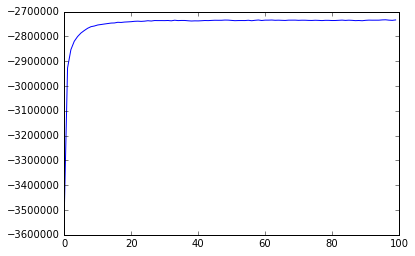

In [13]:
plt.plot(model.loglikelihoods_)

In [14]:
print_topics(model, vocab)

	Topic 1: like, cream, sweet, tea, cake, chocolate, ice, coffee, delicious, just

	Topic 2: food, poisoning, got, night, day, sick, place, stomach, ate, eating

	Topic 3: sick, place, good, great, like, bar, really, nice, just, food

	Topic 4: order, sick, food, said, called, told, manager, restaurant, know, asked

	Topic 5: place, food, people, like, don, just, health, sick, store, dirty

	Topic 6: came, food, table, minutes, service, restaurant, didn, time, waiter, waitress

	Topic 7: food, sushi, sick, place, got, ordered, chicken, poisoning, fish, good

	Topic 8: burger, chicken, sick, cheese, food, like, ordered, got, fries, place

	Topic 9: food, place, sick, ve, good, just, don, like, pizza, really

	Topic 10: sauce, good, chicken, like, just, dish, pork, ordered, soup, restaurant




In [1216]:
from foodbornenyc.models import models as m, documents as d, businesses as b, locations as l
db = m.getDBSession()

In [1217]:
db.query(b.Business).limit(10).all()

[<Business nameu'Asian Fusion'>,
 <Business nameu'Clairmont Diner'>,
 <Business nameu'Palermo Bakery'>,
 <Business nameu'Corato Pizza'>,
 <Business nameu'Hong Cheng Grocery'>,
 <Business nameu'Carifesta Restaurant'>,
 <Business nameu"Dunkin' Donuts">,
 <Business nameu'The Local'>,
 <Business nameu'Bar 131'>,
 <Business nameu'Pret A Manger'>]

In [515]:
%%time
bigreviews = db.query(d.YelpReview).limit(100000).all()

CPU times: user 2.68 s, sys: 353 ms, total: 3.03 s
Wall time: 3.06 s


In [557]:
%%time
fit_sample = [ r.text for r in np.random.choice(bigreviews, size=19000, replace=False)]
posn = 1000
data = pos_data[:posn] +fit_sample
labels = np.concatenate((np.ones(posn), np.zeros(len(sample)))).astype(int)

CPU times: user 174 ms, sys: 6.63 ms, total: 180 ms
Wall time: 178 ms


In [541]:
print len(data)

20000


In [658]:
%%time
result_mixed = run_disclda(data, labels, n_topics=50, n_per=1, n_iter=200)

Running LDA with 50 topics and 200 iterations...
(N,V):  (20000, 10581)

CPU times: user 6min 32s, sys: 856 ms, total: 6min 33s
Wall time: 6min 37s


In [659]:
print_topics(result_mixed['model'], result_mixed['vocab'], top_k=50)

	Topic 1: bar, beer, great, selection, beers, good, place, game, drink, drinks, tap, wings, nice, pretty, watch, friendly, bartenders, bartender, friends, cool, awesome, crowd, pub, night, sports, dive, games, chill, decent, really, cheap, crowded, neighborhood, spot, atmosphere, lots, irish, bars, tv, tvs, fun, staff, big, space, craft, draft, happy, vibe, specials, want

	Topic 2: sick, food, poisoning, got, night, ate, stomach, eating, day, hours, eat, went, diarrhea, vomiting, later, friend, husband, days, bad, ordered, felt, ill, home, worst, feeling, meal, health, feel, restaurant, terrible, started, did, tasted, dinner, friends, morning, bathroom, boyfriend, yesterday, didn, experience, horrible, violently, severe, wife, having, case, threw, department, throwing

	Topic 3: flavor, dish, sauce, perfectly, perfect, bit, sweet, little, crispy, meal, light, just, bread, flavors, cooked, soft, served, nice, texture, rich, taste, fried, right, delicious, bite, menu, warm, creamy, fres

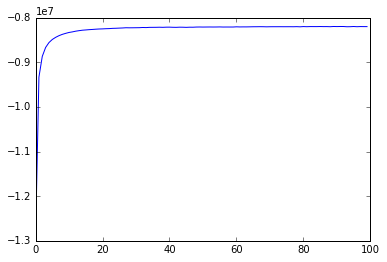

In [660]:
plt.plot(result_mixed['model'].loglikelihoods_)

In [661]:
thetas = result_mixed['model'].doc_topic_

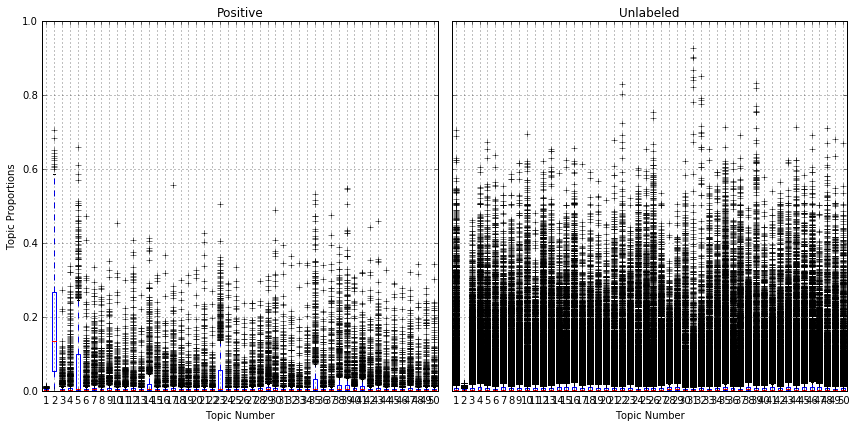

In [662]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
ax0.boxplot(thetas[:posn])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[posn:])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Unlabeled")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
#plt.savefig('lda_boxplot_2500_7500.pdf')

### Fitting the $\Gamma$

In [669]:
import scipy.stats as st
def transform_doc(preprocess, model, doc):
    X = preprocess.transform([doc])
    #print X
    #print np.nonzero(X)
    return model.transform(X)

In [724]:
# get another random sample
gam_sample = [ r.text for r in np.random.choice(bigreviews, size=10000, replace=False)]

In [725]:
# get the alpha_2s of each doc in this sample
gvals = np.array([ transform_doc(result_mixed['cv'], result_mixed['model'], text)[0,1] for text in gam_sample])

In [726]:
# compute empirical gamma params
gbar = np.sum(gvals)/len(gvals)
#print gbar
gbar2 = gbar**2
#print gbar2
g2m = np.sum(gvals**2)/len(gvals)
#print g2m

# calculate shape estimate for gamma
den = g2m - gbar2
#print den
bhat = gbar/den #bhat is the RATE parameter = 1/SCALE
ahat = gbar2/den
print ahat, 1./bhat

0.0725556603173 0.0767093989825


In [1012]:
# frozen empirical gamma for evaluation
empgam = st.gamma(ahat, scale=1./bhat)

In [1013]:
def empgamma(gvals):
    # compute empirical gamma params
    gbar = np.sum(gvals)/len(gvals)
    #print gbar
    gbar2 = gbar**2
    #print gbar2
    g2m = np.sum(gvals**2)/len(gvals)
    #print g2m

    # calculate shape estimate for gamma
    den = g2m - gbar2
    #print den
    bhat = gbar/den #bhat is the RATE parameter = 1/SCALE
    ahat = gbar2/den
    return st.gamma(ahat, scale=1./bhat)

###  Looking at the empirical dist for individual reviews, both labeled and unlabeled

In [728]:
# pos data alpha2s for documents that we 1000 docs we didn't train on
pos_gs = [ transform_doc(result_mixed['cv'], result_mixed['model'], t)[0,1] for t in pos_data[posn:posn+1000]]

(array([ 0.015,  0.024,  0.031,  0.037,  0.031,  0.037,  0.035,  0.034,
         0.032,  0.049,  0.03 ,  0.032,  0.031,  0.035,  0.026,  0.027,
         0.019,  0.023,  0.016,  0.02 ,  0.021,  0.027,  0.024,  0.022,
         0.021,  0.01 ,  0.013,  0.022,  0.013,  0.015,  0.01 ,  0.014,
         0.012,  0.011,  0.012,  0.01 ,  0.007,  0.013,  0.005,  0.007,
         0.005,  0.014,  0.004,  0.009,  0.005,  0.003,  0.006,  0.004,
         0.003,  0.006,  0.005,  0.001,  0.002,  0.006,  0.   ,  0.003,
         0.005,  0.002,  0.   ,  0.001,  0.003,  0.002,  0.003,  0.004,
         0.004,  0.001,  0.004,  0.   ,  0.004,  0.001,  0.001,  0.   ,
         0.001,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.002,
         0.   ,  0.   ,  0.001,  0.001,  0.   ,  0.003,  0.001,  0.   ,
         0.   ,  0.001,  0.   ,  0.   ,  0.001,  0.001,  0.   ,  0.   ,
         0.002,  0.   ,  0.   ,  0.001]),
 array([ 0.0015789 ,  0.01062256,  0.01966623,  0.0287099 ,  0.03775356,
         0.04679723, 

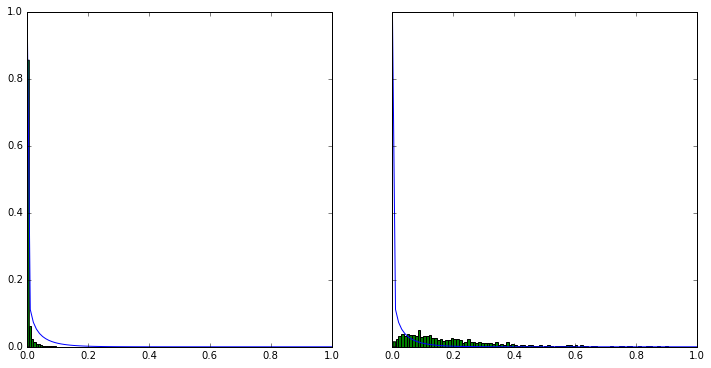

In [729]:
# checking out what this empirical distribution and the fitted gamma look like
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
x = np.linspace(0,1,100)
# unlabeled
ax0.plot(x, 1-empgam.cdf(x))
weights = np.ones_like(gvals)/len(gvals)
ax0.hist(gvals, 100, weights=weights)

#labeled
ax1.plot(x, 1-empgam.cdf(x))
weights = np.ones_like(pos_gs)/len(pos_gs)
ax1.hist(pos_gs, 100, weights=weights)

### Looking pretty good, let's check out outbreak windows now

In [572]:
#get random sample of 100 businesses
bs = db.query(b.Business.id).limit(10000).all()
bids = [biz.id for biz in bs]

In [677]:
samp = npr.choice(bids, 100)
print len(samp)

100


In [678]:
# all reviews for each of those businesses
revs = db.query(d.YelpReview).filter(d.YelpReview.business_id.in_(samp)).all()

In [679]:
print len(revs)

10178


In [680]:
# make a dictionary datastruct for each of those businesses by review for unlabeleds
import logging
logging.getLogger("lda").setLevel(logging.ERROR)
ts = {}
for r in revs:
    try:
        ts[r.business_id].append((r.created, r.text, transform_doc(result_mixed['cv'], result_mixed['model'], r.text)))
    except KeyError:
        ts[r.business_id] = [(r.created, r.text, transform_doc(result_mixed['cv'], result_mixed['model'], r.text))]

In [681]:
# need slightly different form of labeled data for this (dates, and business)
import csv
with open('reviews_foodborne_date_biz.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data_n = [ row for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne_date_biz.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data_n = [ row for row in reader if float(row[1]) == 0.0]

In [682]:
# make a dictionary datastruct of all reviews for the business associated with 100 labeled reviews
ob = pos_data_n[posn:posn+100]
os = {}
for i, rev in enumerate(ob):
    print i
    biz = db.query(b.Business).filter(b.Business.name==unicode(rev[3])).first()
    if not biz: continue
    os[biz.id] = [ (r.created, r.text, transform_doc(result['cv'], result['model'], r.text)) for r in biz.reviews ]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [683]:
# number of reviews for these businesses
print len([ t[2] for r in os.values() for t in r])

21579


In [ ]:
# # lets look
# etas = [t[2][0,1] for a in os.values() for t in a]
# texts = [t[1] for a in os.values() for t in a]

In [583]:
# fig, ax = plt.subplots(1,1, figsize=(9,6))
# ax.plot(x, 1-empgam.cdf(x))
# #weights = np.ones_like(gvals)/len(gvals)
# #ax.hist(gvals, 100, alpha=.5, weights=weights)
# ax.hist(etas, 100, weights = np.ones_like(etas)/len(etas), alpha=.3)
# ax.set_ylim((0,.1))
# ax.set_xlim((0,.5))

In [586]:
# create the timedelta for creating windows
import datetime
# delta = datetime.timedelta(30) # two months
# delta = datetime.timedelta(15) # one month
delta = datetime.timedelta(7) # two week
# delta = datetime.timedelta(4) # one week

In [684]:
# get all of the reviews which we know are labeled as a list for convenience
knowns = [ unicode(r[0], 'utf-8') for r in ob]

In [685]:
# probs = [empgam.cdf(eta) for eta in etas]
# oldc =0
# for e,t in sorted(zip(probs, texts), key=lambda x:x[0], reverse=True)[:100]:
#     if t in knowns: 
#         new=False
#         oldc +=1
#     else: new=True
# #     print "%r, %r: %r"% (new, e,t)
# #     print

In [686]:
# get dict of biz names for display purposes
biz_names = {}
for bid in ts.keys():
    try:
        biz = db.query(b.Business).filter(b.Business.id==bid).first()  
        biz_names[bid] = biz.name
    except:
        biz_names[bid] = u"UNKNOWN"

for bid in os.keys():
    try:
        biz = db.query(b.Business).filter(b.Business.id==bid).first()  
        biz_names[bid] = biz.name
    except:
        biz_names[bid] = u"UNKNOWN"
        

In [687]:
outbreaks = []
windows = []

In [688]:
# get all windows associated with a business that had a labeled food poisoning review
for o in os.items():
    for datum in o[1]:
        revs = [ item for item in o[1] if (item[0] > (datum[0]-delta)) and (item[0] < (datum[0]+delta)) ]
        window_d = [r[0] for r in revs ]
        window_t = [r[1] for r in revs ]
        window_eta =[r[2][0,1] for r in revs]
        if datum[1] in knowns: outbreak=True
        else: outbreak=False
        dic = {'biz': o[0],
               'bname': biz_names[o[0]],
               'window_d':window_d,
               'window_t': window_t,
               'window_eta':window_eta,
               'outbreak': outbreak}
        outbreaks.append(dic)

In [689]:
# do the same for the unlabeled random sample of restaurants
for o in ts.items():
    for datum in o[1]:
        revs = [ item for item in o[1] if (item[0] > (datum[0]-delta)) and (item[0] < (datum[0]+delta)) ]
        window_d = [r[0] for r in revs ]
        window_t = [r[1] for r in revs ]
        window_eta =[r[2][0,1] for r in revs]
        if datum[1] in knowns: outbreak=True
        else: outbreak=False
        dic = {'biz': o[0],
               'bname': biz_names[o[0]],
               'window_d':window_d,
               'window_t': window_t,
               'window_eta':window_eta,
               'outbreak': outbreak}
        windows.append(dic)

In [690]:
#number of windows
print len(outbreaks)
print len(windows)

21579
10178


In [691]:
# avg number of docs in each window type (hopefully are similar)
print sum([len(w) for w in outbreaks])/float(len(outbreaks))
print sum([len(w) for w in windows])/float(len(windows))

6.0
6.0


In [742]:
# compute the window outbreak scores
for w in outbreaks:
    n = len(w['window_eta'])
    s = np.sum(np.array(w['window_eta']))
    gam = st.gamma(n*ahat, scale=1./bhat)
    score = gam.cdf(s)
#     print n, s, score
#     for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
#         print "%r, %0.3f, %r" % (date.strftime("%m-%d-%y"), eta, t)
#         print
#     print
#     print
    w['outbreak_score'] = score
    w['outbreak_s'] = s

In [743]:
# do the same for the unlabeled windows
for w in windows:
    n = len(w['window_eta'])
    s = np.sum(np.array(w['window_eta']))
    gam = st.gamma(n*ahat, scale=1./bhat)
    score = gam.cdf(s)
    #print n, s, score
    #for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
        #print "%r, %0.3f, %r" % (date.strftime("%m-%d-%y"), eta, t)
        #print
    #print
    #print
    w['outbreak_score'] = score
    w['outbreak_s'] = s

In [745]:
# compute the average outbreak score
w_scores = [ w['outbreak_score'] for w in windows]
o_scores = [ w['outbreak_score'] for w in outbreaks]
w_avg_score = np.sum(np.array(w_scores))/len(w_scores)
o_avg_score = np.sum(np.array(o_scores))/len(o_scores)

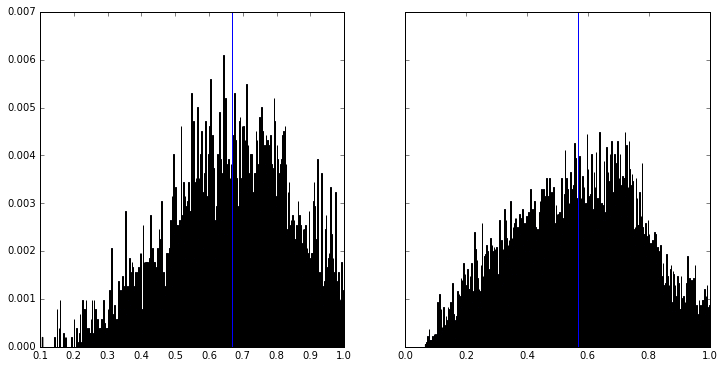

In [750]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6), sharey=True)
# plot how these scores look
weights = np.ones_like(w_scores)/len(w_scores)
# plt.plot(x, empgam.cdf(x))
ax0.hist(w_scores, 500, weights=weights)
ax0.axvline(x=w_avg_score)

oweights = np.ones_like(o_scores)/len(o_scores)
ax1.hist(o_scores, 500, weights=oweights)
ax1.axvline(x=o_avg_score)

In [739]:
# let's look at our top predictions
tops = sorted(windows, key=lambda x:x['outbreak_score'], reverse=True)

In [740]:
top = []
unique = []
for w in tops:
    if not w['bname'] in unique:
        top.append(w)
        unique.append(w['bname'])
        

In [741]:
for w in top[:50]:
    print "Biz: %r, Score: %.3f" % (w['bname'], w['outbreak_score'])
    for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
        print "%r, %0.3f, %r" % (date.strftime("%m-%d-%y"), eta, t)
        print
    print
    print

Biz: u'Kun Jip', Score: 1.000
'08-05-14', 0.754, u'Do not get the Yook Hye Jang here....I got really bad food poisoning the other day and am still recovering.'

'08-05-14', 0.001, u'This place is absolute crap. It doesn\'t deserve a star because it\'s the definition if being conned in Korea town, but that\'s not even an option on yelp. Please don\'t be fooled by the lines. People go here because they seem to think bad quality and rude lacking service is somehow the cool equivalent of roughing it as though you were really in Korea- as though that makes it "authentic." After walking down the K-town row of restaurants I wanted to be a little adventurous and try a new place. I came here for Korean BBQ because it was crowded and seemed busy. Upon entering they pushed us to the back by the bathrooms. It was weird. They took our orders as we were on the line at the back of the restaurant. The manager with her little headset kept telling me to move up on the line not realizing I would be block

In [751]:
# let's look at our top predictions
tops = sorted(outbreaks, key=lambda x:x['outbreak_score'], reverse=True)

In [752]:
top = []
unique = []
for w in tops:
    if not w['bname'] in unique:
        top.append(w)
        unique.append(w['bname'])
        

In [755]:
for w in top[:50]:
    print "Known?%s, Biz: %r, Score: %.3f" % (w['outbreak'],w['bname'], w['outbreak_score'])
    for date, eta,  t in sorted(zip(w['window_d'],w['window_eta'], w['window_t']), key=lambda x:x[0]):
        print "%r, %0.3f, %r" % ( date.strftime("%m-%d-%y"), eta, t)
        print
    print
    print

Known?False, Biz: u'Happy Days Diner', Score: 1.000
'05-19-14', 0.423, u'They should be shut down by the Dept of Health.  The place is disgusting and the food not fit for human consumption.'

'05-22-14', 0.001, u"This place gets a bad rap from some but I gotta say it's treated me well.  I've eaten there and ordered in a number of times and things are always solid (this is diner food, folks).  They're corned beef hash is top notch, as are their sundaes, if you're in the mood.  Also one of very few 24 hour joints in Brooklyn Heights."



Known?False, Biz: u'Pinche Taqueria', Score: 1.000
'12-20-10', 0.158, u'I HAVE NEVER IN MY LIFE GOTTEN SO SICK FROM FOOD!\n\nMy boyfriend and I almost died from the food poisoning that this lovely establishment so kindly delivered to us. We shared a steak taco salad and became violently ill for the 24 hours that followed our "meal"\n\nWill NEVER go back and after reading how many other people have gotten sick there, curse the staff and the management for

### Ok, so it seems like it sort of works for outbreaks.  Let's try for individual reviews sample

In [761]:
ind_sample = [r.text for r in npr.choice(bigreviews, 10000, replace=False)]

In [762]:
ind_gs = [transform_doc(result_mixed['cv'], result_mixed['model'], t )[0,1] for t in ind_sample]

(array([  8.56400000e-01,   6.29000000e-02,   2.41000000e-02,
          1.27000000e-02,   1.04000000e-02,   6.40000000e-03,
          2.90000000e-03,   3.80000000e-03,   2.50000000e-03,
          2.30000000e-03,   1.80000000e-03,   2.30000000e-03,
          9.00000000e-04,   1.20000000e-03,   1.00000000e-03,
          5.00000000e-04,   1.00000000e-03,   7.00000000e-04,
          4.00000000e-04,   7.00000000e-04,   1.00000000e-04,
          6.00000000e-04,   6.00000000e-04,   4.00000000e-04,
          4.00000000e-04,   0.00000000e+00,   0.00000000e+00,
          1.00000000e-04,   0.00000000e+00,   2.00000000e-04,
          0.00000000e+00,   1.00000000e-04,   2.00000000e-04,
          2.00000000e-04,   1.00000000e-04,   2.00000000e-04,
          0.00000000e+00,   0.00000000e+00,   3.00000000e-04,
          0.00000000e+00,   1.00000000e-04,   0.00000000e+00,
          0.00000000e+00,   2.00000000e-04,   1.00000000e-04,
          0.00000000e+00,   0.00000000e+00,   2.00000000e-04,
        

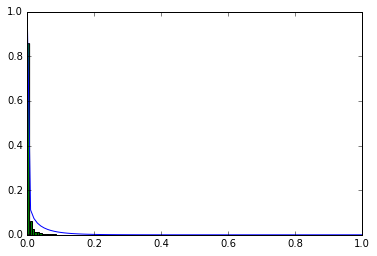

In [763]:
# does this look consistent?
x = np.linspace(0,1,100)
plt.plot(x, 1-empgam.cdf(x))

weights = np.ones_like(ind_gs)/len(ind_gs)
plt.hist(ind_gs, 100, weights=weights)

In [767]:
# so now lets print the docs in ranked reverse order by score
ind_scores = [ empgam.cdf(g) for g in ind_gs ]
for t, s in sorted(zip(ind_sample, ind_scores), key=lambda x:x[1], reverse=True):
    print "%.3f: %r" % (s,t)
    print

1.000: u"My friend's and I got food poisoning from the Sushi on Monday Jan 27, 2014... Very sick... :("

1.000: u'I ordered a nicoise salad for lunch which made me violently ill. I went home and got sick for several hours. I was fine once the vomiting stopped.  Food poisoning is never fun.'

1.000: u'Got chicken, lamb, and rice for dinner and immediately following the next morning, I had gastroenteritis or commonly known as the stomach flu. I did not eat anything prior nor anything after so this is the only food that could have caused it. I never had such a bad experience with food before...Will not be visiting ever again.'

1.000: u'Dined at this restaurant last night and had an decent meal however I got severe food poisoning from the pork tacos I consumed. Contacted the restaurant\'s manager and all they offered was, "Are you sure you\'re not allergic to pork?" Terrible customer service and not very reassuring for future diners. Beware of the food.'

1.000: u'Apparently closed by the

## Local Definition of the DiscLDA class

## Experiment 1 Testing DiscLDA accuracy for individual review classification

In [1088]:
# pull in rows and sort them by date
rows = []
with open('reviews_foodborne_date_biz.csv') as f:
    for i, row in enumerate(csv.reader(f)):
        if i == 0 : continue
        row[1] = int(float(row[1]))
        row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
        rows.append(row)

# sort by date
rows = sorted(rows, key=lambda x:x[2])
            
# grab first 1000 by date
data = {'X':[], 'y':[]}
for i, row in enumerate(rows):
        data['X'].append(row[0])
        data['y'].append(row[1])
        if i == 1000:
            break
data['y'] = np.array(data['y'])

# grab sceond 1000 by date
testdata = {'X':[], 'y':[]}
for i, row in enumerate(rows[1001:2001]):
        testdata['X'].append(row[0])
        testdata['y'].append(row[1])
        if i == 1000:
            break
testdata['y'] = np.array(testdata['y'])

In [1063]:
print 'Positives: ', len([y for y in data['y'] if y == 1])
print 'Negatives: ', len([y for y in data['y'] if y == 0])

Positives:  440
Negatives:  561


In [1064]:
print 'Positives: ', len([y for y in testdata['y'] if y == 1])
print 'Negatives: ', len([y for y in testdata['y'] if y == 0])

Positives:  470
Negatives:  530


In [1136]:
result_bias = run_disclda(data['X'], data['y'], n_topics=2, n_iter=200)#run_disclda(data, labels, n_topics=10, n_per=1, n_iter=1000, random_state=0)

Running LDA with 2 topics and 200 iterations...
(N,V):  (1001, 2582)



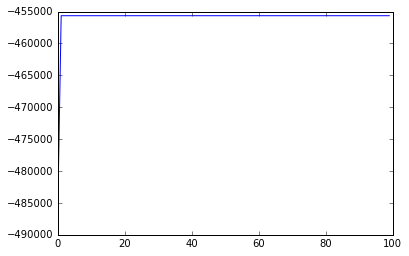

In [1137]:
plt.plot(result_bias['model'].loglikelihoods_)

In [1138]:
thetas = result_bias['model'].doc_topic_
#print len(thetas[data['y'] == 0])
#print data['y']

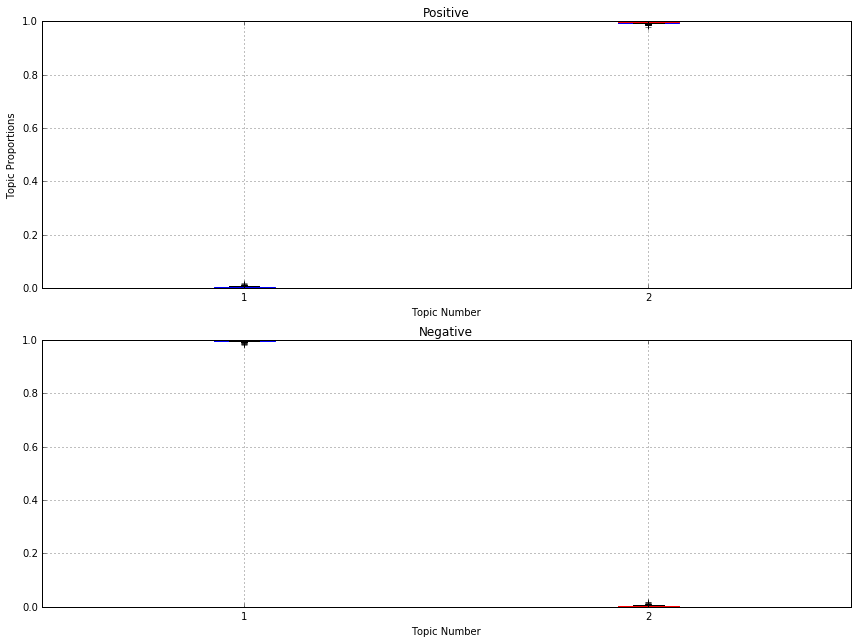

In [1139]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
ax0.boxplot(thetas[np.where(data['y'] == 1)])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[np.where(data['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Negative")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
#plt.savefig('lda_boxplot_2500_7500.pdf')

In [1140]:
print_topics(result_bias['model'], result_bias['vocab'], top_k=20)

	Topic 1: food, sick, place, like, just, good, really, don, got, ve, great, time, ordered, order, chicken, didn, service, know, came, come

	Topic 2: food, sick, place, got, poisoning, food poisoning, good, just, ordered, like, really, time, chicken, bad, eat, eating, don, night, restaurant, know




In [1141]:
testthetas = np.array([transform_doc(result_bias['cv'], result_bias['model'], doc)[0,:] for doc in testdata['X']])

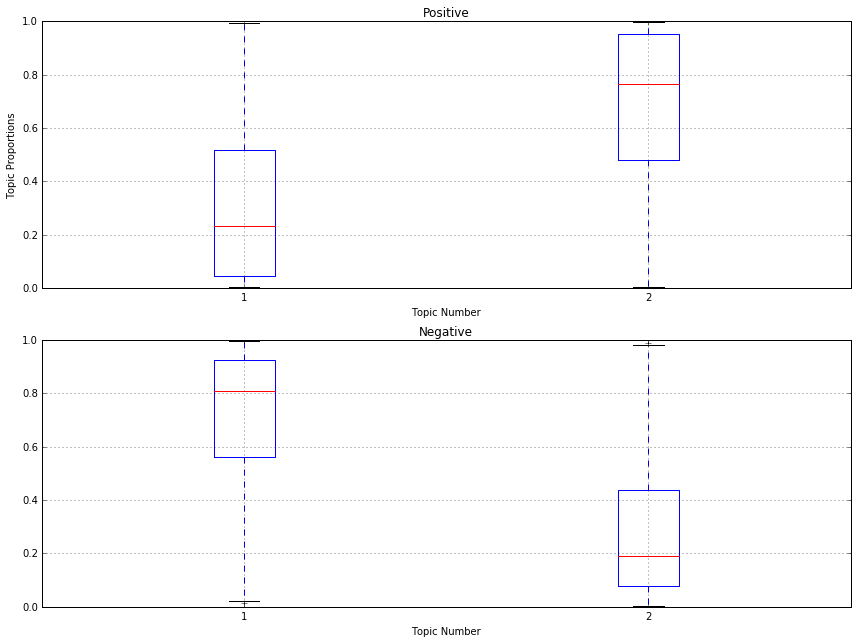

In [1142]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
ax0.boxplot(testthetas[np.where(testdata['y'] == 1)])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(testthetas[np.where(testdata['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Negative")
ax1.set_xlabel("Topic Number")

plt.tight_layout()

In [1143]:
testlabels = testdata['y']
testscores = testthetas[:,1]

#convert them to gamma probs
#print thetas
testscores = empgamma(thetas[:,1]).cdf(testscores)
#print testscores

In [1144]:
from sklearn.metrics import roc_curve, auc

In [1145]:
fpr, tpr, _ = roc_curve(testlabels, testscores)
s = auc(fpr, tpr)

In [1146]:
# define baseline pipelines
from sklearn.linear_model import LogisticRegression
from sklearn import svm

lr = LogisticRegression(C=1.0,
                        fit_intercept=True,
                        random_state=0,
                        n_jobs=2)
sv = svm.SVC( C=1.0,
              kernel='linear')
svr = svm.SVC( C=1.0,
              kernel='rbf')

In [1147]:
lr.fit(result_bias['X'], data['y'])
sv.fit(result_bias['X'], data['y'])
svr.fit(result_bias['X'], data['y'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel=u'rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1148]:
testX = result_bias['cv'].transform(testdata['X'])
lrscores = lr.predict_proba(testX)[:,1]
svscores = sv.decision_function(testX)[:]
svrscores = svr.decision_function(testX)[:]

In [1149]:
lrfpr, lrtpr, _ = roc_curve(testlabels, lrscores)
lrs = auc(lrfpr, lrtpr)
svfpr, svtpr, _ = roc_curve(testlabels, svscores)
svs = auc(svfpr, svtpr)
svrfpr, svrtpr, _ = roc_curve(testlabels, svrscores)
svrs = auc(svrfpr, svrtpr)

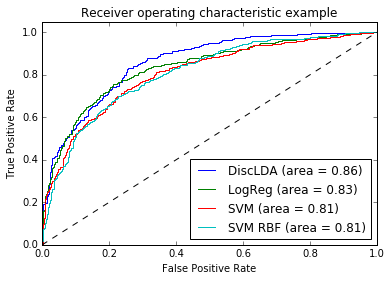

In [1150]:
plt.figure()
plt.plot(fpr, tpr, label='DiscLDA (area = %0.2f)' % s)
plt.plot(lrfpr, lrtpr, label='LogReg (area = %0.2f)'% lrs)
plt.plot(svfpr, svtpr, label='SVM (area = %0.2f)'% svs)
plt.plot(svrfpr, svrtpr, label='SVM RBF (area = %0.2f)'% svrs)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   1.,
          0.,   5.,   2.,   3.,   3.,   6.,   4.,   5.,  20.,  11.,  28.,
         34.,  40.,  42.,  48.,  56.,  48.,  48.,  29.,  22.,  17.,   6.,
          6.,   7.,  10.,   7.,   4.,   4.,   3.,   2.,   0.,   3.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([ 0.        ,  0.01438732,  0.02877464,  0.04316197,  0.05754929,
         0.07193661,  0.08632393,  0.10071125,  0.11509858,  0.1294859 ,
         0.14387322,  0.15826054,  0.17264786,  0.18703519,  0.20142251,
         0.21580983,  0.23019715,  0.24458447,  0.25897179,  0.27335912,
         0.28774644,  0.30213376,  0.31652108,  0.3309084 ,  0.34529573,
         0.35968305,  0.37407037,  0.38845769,  0.40284501,  0.41723234,
         0.43161966,  0.44600698,  0.4603943 ,  0.47478162,  0.48916895,
         0.50355627,  0.51794359,  0.53233091,  0.54671823,  0.56110556,
         0.57549288,  0.5898802 ,  0.60426752,  0.61865484,  0.63304216,
 

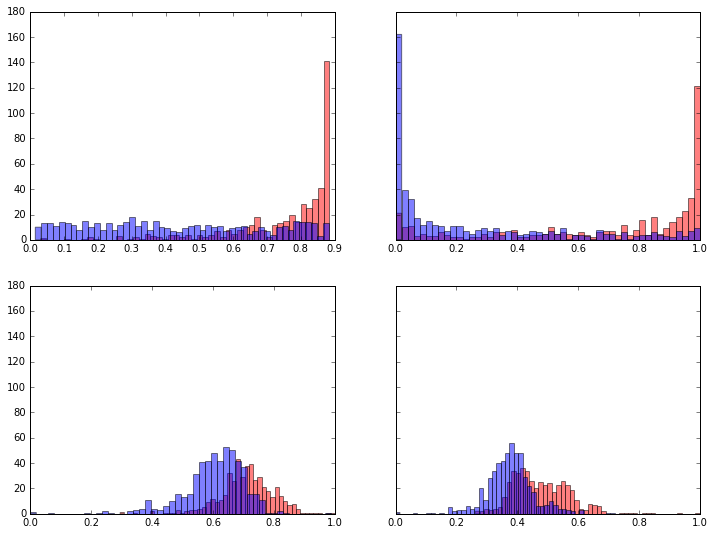

In [1151]:
# plot the histograms of the values for each
# normalize decision function scores
norm_svscores = (1./(max(svscores)-min(svscores)))*(svscores - min(svscores))
norm_svrscores = (1./(max(svrscores)-min(svrscores)))*(svrscores - min(svrscores))

fig, axarr = plt.subplots(2,2, figsize=(12,9), sharey=True)
axarr[0,0].hist([s for s in testscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[0,0].hist([s for s in testscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# axarr[0,1].hist(lrscores)
axarr[0,1].hist([s for s in lrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[0,1].hist([s for s in lrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# axarr[1,0].hist(norm_svscores)
axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# axarr[1,1].hist(norm_svrscores)
axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

## Experiment 2 Testing DiscLDA accuracy for individual review classification for unlabeleds

In [1152]:
# what happens when I add some unlabeleds for context

In [1185]:
# pull in rows and sort them by date
rows = []
with open('reviews_foodborne_date_biz.csv') as f:
    for i, row in enumerate(csv.reader(f)):
        if i == 0 : continue
        row[1] = int(float(row[1]))
        row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
        rows.append(row)

# sort by date
rows = sorted(rows, key=lambda x:x[2])
            
# grab first 1000 by date
data = {'X':[], 'y':[]}
for i, row in enumerate(rows):
        data['X'].append(row[0])
        data['y'].append(row[1])
        if i == 1000:
            break
data['y'] = np.array(data['y'])

# grab sceond 1000 by date
testdata = {'X':[], 'y':[]}
for i, row in enumerate(rows[1001:2001]):
        testdata['X'].append(row[0])
        testdata['y'].append(row[1])
        if i == 1000:
            break
testdata['y'] = np.array(testdata['y'])
print data['y'].shape

(1001,)


In [1201]:
# supplement negative with a bunch of unlabeled
n_extra = 10000
unlabeled = [ t.text for t in np.random.choice(bigreviews, n_extra, replace=False)]
data['X'].extend(unlabeled)
data['y'] = np.append(data['y'],np.zeros(len(unlabeled)))

In [1202]:
result_bias = run_disclda(data['X'], data['y'], n_topics=5, n_iter=200)#run_disclda(data, labels, n_topics=10, n_per=1, n_iter=1000, random_state=0)

Running LDA with 5 topics and 200 iterations...
(N,V):  (12001, 15482)



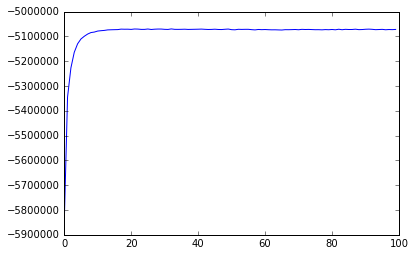

In [1203]:
plt.plot(result_bias['model'].loglikelihoods_)

In [1204]:
thetas = result_bias['model'].doc_topic_
#print len(thetas[data['y'] == 0])
#print data['y']

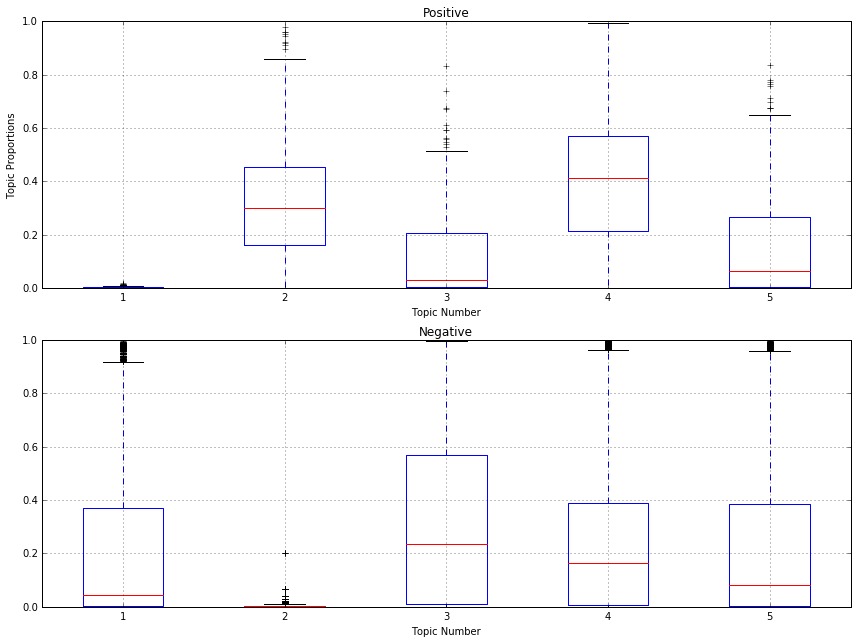

In [1205]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
ax0.boxplot(thetas[np.where(data['y'] == 1)])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(thetas[np.where(data['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Negative")
ax1.set_xlabel("Topic Number")

plt.tight_layout()
#plt.savefig('lda_boxplot_2500_7500.pdf')

In [1206]:
print_topics(result_bias['model'], result_bias['vocab'], top_k=20)

	Topic 1: food, good, chicken, place, like, really, rice, ve, sauce, just, pork, soup, great, sushi, lunch, best, spicy, meat, definitely, pretty

	Topic 2: food, sick, poisoning, got, place, chicken, eating, ate, ordered, eat, stomach, bad, meat, night, taste, good, really, just, tasted, sushi

	Topic 3: place, good, great, like, bar, just, love, really, food, nice, coffee, best, pizza, ve, friendly, little, drinks, time, pretty, staff

	Topic 4: food, place, just, time, like, order, service, don, didn, people, got, said, ordered, came, table, did, know, minutes, went, asked

	Topic 5: good, great, food, delicious, service, cheese, ordered, restaurant, menu, came, really, place, nice, salad, dinner, sauce, just, like, brunch, dish




In [1207]:
testthetas = np.array([transform_doc(result_bias['cv'], result_bias['model'], doc)[0,:] for doc in testdata['X']])

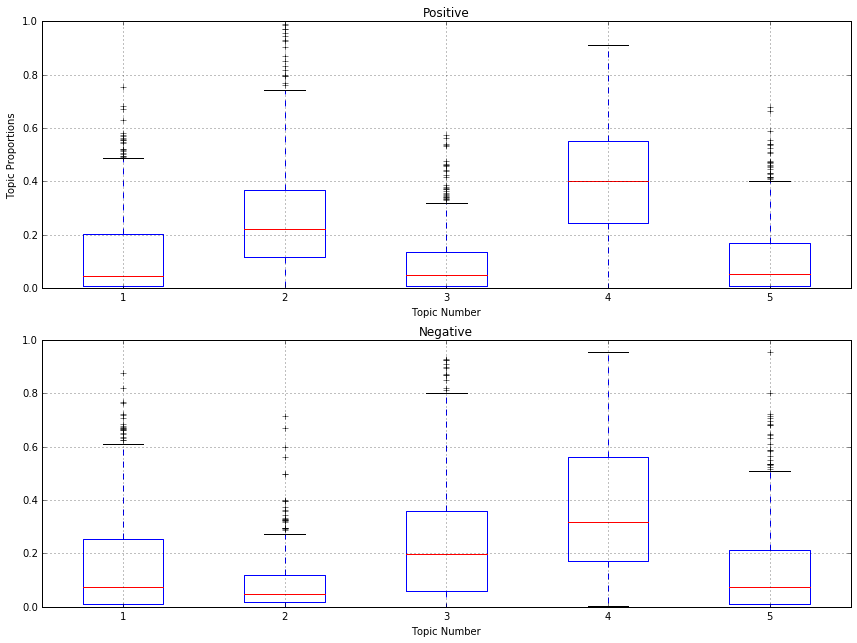

In [1208]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,9), sharey=True)
ax0.boxplot(testthetas[np.where(testdata['y'] == 1)])
ax0.grid()
ax0.set_title("Positive")
ax0.set_xlabel("Topic Number")
ax0.set_ylabel("Topic Proportions")
ax1.boxplot(testthetas[np.where(testdata['y'] == 0)])#np.random.randint(2500,10000,size=2500),:])
ax1.grid()
ax1.set_title("Negative")
ax1.set_xlabel("Topic Number")

plt.tight_layout()

In [1209]:
testlabels = testdata['y']
testscores = testthetas[:,1]

#convert them to gamma probs
#print thetas
testscores = empgamma(thetas[:,1]).cdf(testscores)
#print testscores

In [1210]:
# define baseline pipelines
from sklearn.linear_model import LogisticRegression
from sklearn import svm

lr = LogisticRegression(C=1.0,
                        fit_intercept=True,
                        random_state=0,
                        n_jobs=2)
sv = svm.SVC( C=1.0,
              kernel='linear')
svr = svm.SVC( C=1.0,
              kernel='rbf')
lr.fit(result_bias['X'], data['y'])
sv.fit(result_bias['X'], data['y'])
svr.fit(result_bias['X'], data['y'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel=u'rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1211]:
fpr, tpr, _ = roc_curve(testlabels, testscores)
s = auc(fpr, tpr)

testX = result_bias['cv'].transform(testdata['X'])
lrscores = lr.predict_proba(testX)[:,1]
svscores = sv.decision_function(testX)[:]
svrscores = svr.decision_function(testX)[:]

lrfpr, lrtpr, _ = roc_curve(testlabels, lrscores)
lrs = auc(lrfpr, lrtpr)
svfpr, svtpr, _ = roc_curve(testlabels, svscores)
svs = auc(svfpr, svtpr)
svrfpr, svrtpr, _ = roc_curve(testlabels, svrscores)
svrs = auc(svrfpr, svrtpr)

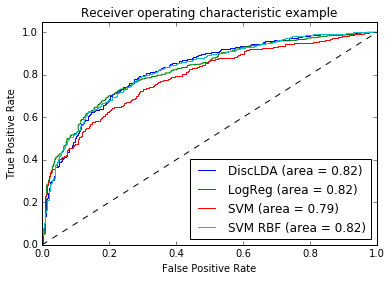

In [1212]:
plt.figure()
plt.plot(fpr, tpr, label='DiscLDA (area = %0.2f)' % s)
plt.plot(lrfpr, lrtpr, label='LogReg (area = %0.2f)'% lrs)
plt.plot(svfpr, svtpr, label='SVM (area = %0.2f)'% svs)
plt.plot(svrfpr, svrtpr, label='SVM RBF (area = %0.2f)'% svrs)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   2.,   0.,   1.,   2.,   2.,   2.,   5.,   7.,   5.,  10.,
         18.,  26.,  37.,  32.,  41.,  44.,  63.,  65.,  45.,  29.,  27.,
         17.,  15.,   9.,   6.,   6.,   2.,   3.,   0.,   2.,   0.,   0.,
          2.,   0.,   1.,   0.,   0.,   2.]),
 array([ 0.        ,  0.01268921,  0.02537841,  0.03806762,  0.05075682,
         0.06344603,  0.07613524,  0.08882444,  0.10151365,  0.11420286,
         0.12689206,  0.13958127,  0.15227047,  0.16495968,  0.17764889,
         0.19033809,  0.2030273 ,  0.21571651,  0.22840571,  0.24109492,
         0.25378412,  0.26647333,  0.27916254,  0.29185174,  0.30454095,
         0.31723015,  0.32991936,  0.34260857,  0.35529777,  0.36798698,
         0.38067619,  0.39336539,  0.4060546 ,  0.4187438 ,  0.43143301,
         0.44412222,  0.45681142,  0.46950063,  0.48218984,  0.49487904,
         0.50756825,  0.52025745,  0.53294666,  0.54563587,  0.55832507,
 

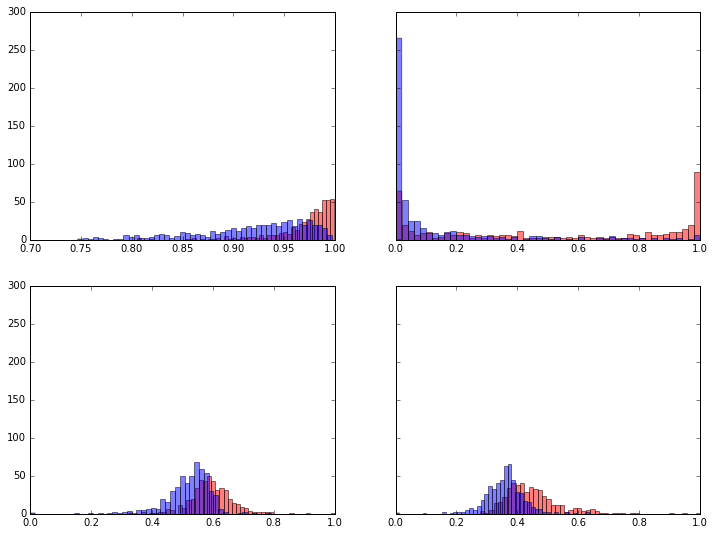

In [1213]:
# plot the histograms of the values for each
# normalize decision function scores
norm_svscores = (1./(max(svscores)-min(svscores)))*(svscores - min(svscores))
norm_svrscores = (1./(max(svrscores)-min(svrscores)))*(svrscores - min(svrscores))

fig, axarr = plt.subplots(2,2, figsize=(12,9), sharey=True)
axarr[0,0].hist([s for s in testscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[0,0].hist([s for s in testscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# axarr[0,1].hist(lrscores)
axarr[0,1].hist([s for s in lrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[0,1].hist([s for s in lrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# axarr[1,0].hist(norm_svscores)
axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[1,0].hist([s for s in norm_svscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')

# axarr[1,1].hist(norm_svrscores)
axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==1)]], 50, alpha=.5, color='r')
axarr[1,1].hist([s for s in norm_svrscores[np.where(testlabels ==0)]], 50, alpha=.5, color='b')